In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    GlobalAveragePooling1D, BatchNormalization, LeakyReLU, Dropout

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#Read the data
df = pd.read_csv('news.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
stop = stopwords.words('english')

def clean_text(text):
    text = text.lower()
    text = text.replace("[^a-zA-Z#]", " ")
    text = text.replace('http\S+|www.\S+|.com\S+', '')
    text = re.sub("#+","", text)
    text = re.sub("@[\w]*","", text)
    text = re.sub("[^a-z0-1\s]","", text)
    text = re.sub("@[A-Za-z0-9_]+","", text)

    return text

In [4]:
# df['clean_text'] = df['text'].apply(clean_text)
# df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df['clean_text'] = df['text'] \
                    .apply(clean_text) \
                    .apply(lambda x: ' '.join([word for word in x.split() if len(word)>3])) \
                    .apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [5]:
df['label'] = [0 if i == 'FAKE' else 1 for i in df['label']]

87       60
0        36
49       23
62       17
48       17
         ..
729       1
3217      1
3218      1
3219      1
67374     1
Length: 4074, dtype: int64


<Axes: xlabel='0'>

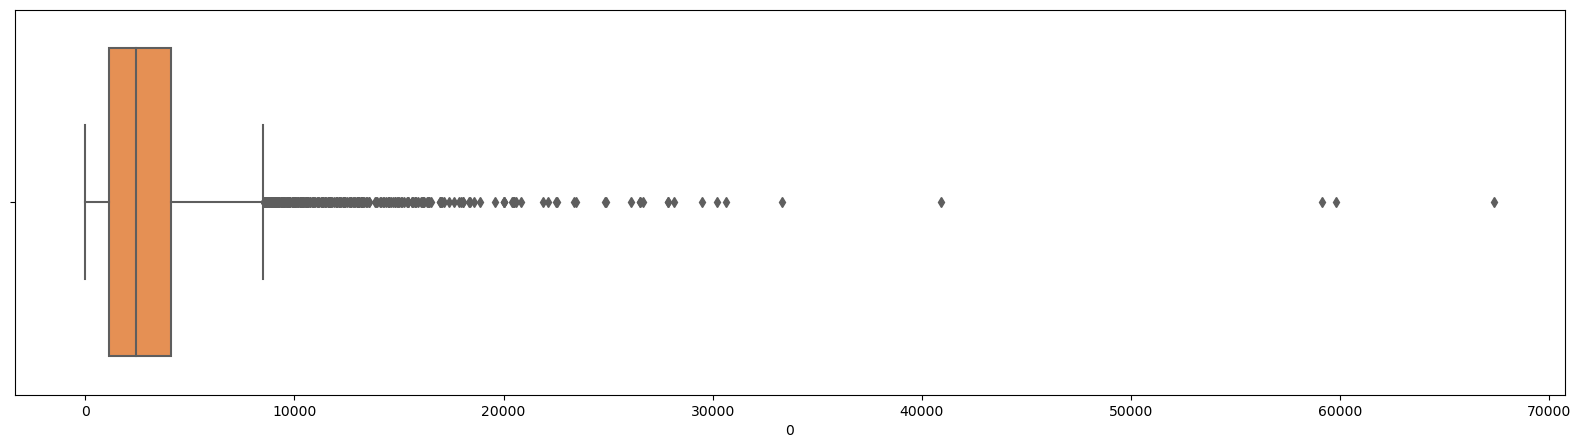

In [6]:
max_text = 0
text_len = []

for idx, teks in enumerate(df['clean_text']):
    text_len.append(len(teks))

text_len_df = pd.DataFrame(text_len)
print(text_len_df.value_counts())

fig, axes = plt.subplots(figsize=(20, 5))
sns.boxplot(x=text_len_df[0], palette="Oranges")

### Supervise Learning Model

In [7]:
#DataFlair - Get the labels
labels=df.label
labels.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

In [12]:
#DataFlair - Split the dataset
# x_train,x_test,y_train,y_test=train_test_split(df['text'], labels, test_size=0.2, random_state=7)
x_train,x_test,y_train,y_test=train_test_split(df['clean_text'], labels, test_size=0.2, random_state=7)

In [13]:
#DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)

#DataFlair - Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

In [14]:
#DataFlair - Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

#DataFlair - Predict on the test set and calculate accuracy
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 93.05%


In [15]:
#DataFlair - Build confusion matrix
confusion_matrix(y_test,y_pred, labels=['FAKE','REAL'])

array([[592,  46],
       [ 42, 587]], dtype=int64)

### Deep Learning Model

In [7]:
x = df['clean_text']
y = pd.get_dummies(df['label'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [14]:
# model configuration

vocab_size = 3300
embedding_dim = 300
max_length = 3300
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [10]:
# preproccess : Tokenizing 

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

#padding
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding = padding_type)

# convert to numpy array
training_padded = np.array(training_padded)
training_label = np. array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np. array(y_test)

In [11]:
print(len(word_index))

80333


In [12]:
# model
model = tf.keras.Sequential([
                            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                            tf.keras.layers.GlobalAveragePooling1D(),
                            tf.keras.layers.Dense(32, activation='sigmoid'),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(1, activation='sigmoid')
])

def DNN_Model():
    dnn_model = Sequential()
    dnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    dnn_model.add(GlobalAveragePooling1D())

    # dnn_model.add(Dense(2048))
    # dnn_model.add(LeakyReLU(0.2))
    # dnn_model.add(Dropout(0.5))
    # dnn_model.add(BatchNormalization())

    # dnn_model.add(Dense(512))
    # dnn_model.add(LeakyReLU(0.2))
    # dnn_model.add(Dropout(0.5))
    # dnn_model.add(BatchNormalization())

    dnn_model.add(Dense(128))
    dnn_model.add(LeakyReLU(0.2))
    dnn_model.add(Dropout(0.5))
    dnn_model.add(BatchNormalization())

    # dnn_model.add(Dense(1, activation='sigmoid'))
    dnn_model.add(Dense(2, activation='softmax'))
    return dnn_model

model = DNN_Model()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [13]:
num_epoch = 10
history = model.fit(training_padded, training_label, 
                    batch_size=8, epochs=num_epoch, 
                    validation_split=0.1)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/embedding_1/embedding_lookup' defined at (most recent call last):
    File "c:\Users\indiz\miniconda3\envs\gan\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\indiz\miniconda3\envs\gan\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\indiz\AppData\Local\Temp\ipykernel_17656\165671982.py", line 2, in <module>
      history = model.fit(training_padded, training_label,
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_1/embedding_1/embedding_lookup'
OOM when allocating tensor with shape[8,3300,80334] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/embedding_1/embedding_lookup}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1223]

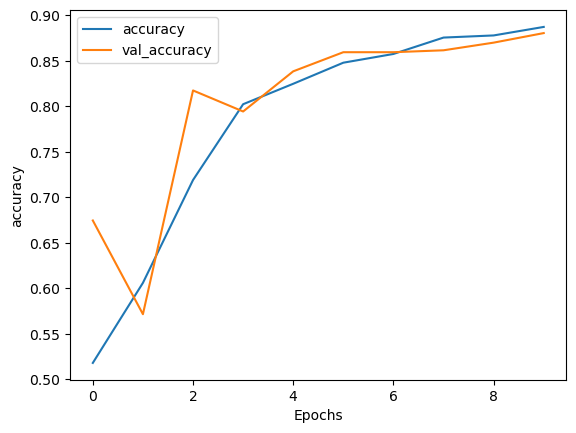

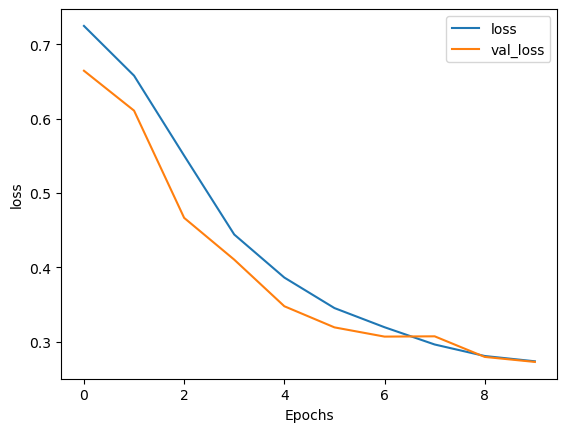

In [12]:
# display history

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [44]:
def build_rnn_model():
    sequences = layers.Input(shape=(max_length,))
    embedded = layers.Embedding(vocab_size, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model
    
rnn_model = build_rnn_model()

In [45]:
rnn_model.fit(training_padded, training_label, 
    batch_size=32,
    epochs=1,
    validation_split=0.1 )

134/134 [==============================] - 79s 411ms/step - loss: 0.6942 - binary_accuracy: 0.5015 - val_loss: 0.6953 - val_binary_accuracy: 0.4685


In [137]:
def LSTM_model():
    lstm_model = Sequential()
    lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    lstm_model.add(LSTM(units=32))
    lstm_model.add(Dense(units=1))
    lstm_model._name = 'LSTM_Model'
    return lstm_model

def GRU_Model():
    gru_model = Sequential()
    gru_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    gru_model.add(GRU(units=32))
    gru_model.add(Dense(units=1))
    gru_model._name = 'GRU_Model'
    return gru_model

rnn_model = GRU_Model()
rnn_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [140]:
rnn_hist = rnn_model.fit(training_padded, training_label, epochs=10, batch_size=32, 
                validation_split=0.1, verbose=1)

Epoch 1/10
134/134 [==============================] - 27s 182ms/step - loss: 0.7257 - accuracy: 0.4980 - val_loss: 0.6903 - val_accuracy: 0.5315
Epoch 2/10
134/134 [==============================] - 25s 184ms/step - loss: 0.6951 - accuracy: 0.4922 - val_loss: 0.6901 - val_accuracy: 0.5315
Epoch 3/10
134/134 [==============================] - 25s 186ms/step - loss: 0.6953 - accuracy: 0.4840 - val_loss: 0.6998 - val_accuracy: 0.4706
Epoch 4/10
134/134 [==============================] - 25s 185ms/step - loss: 0.6928 - accuracy: 0.5029 - val_loss: 0.6899 - val_accuracy: 0.5315
Epoch 5/10
134/134 [==============================] - 25s 186ms/step - loss: 0.6929 - accuracy: 0.5020 - val_loss: 0.6898 - val_accuracy: 0.5315
Epoch 6/10
134/134 [==============================] - 24s 177ms/step - loss: 0.6924 - accuracy: 0.5027 - val_loss: 0.6899 - val_accuracy: 0.5315
Epoch 7/10
134/134 [==============================] - 24s 176ms/step - loss: 0.6929 - accuracy: 0.4830 - val_loss: 0.6899 - val_ac

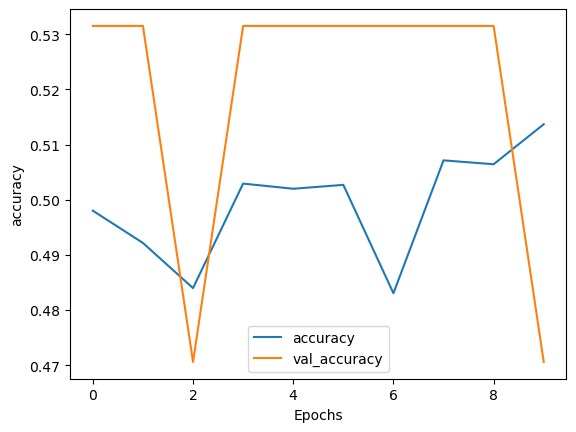

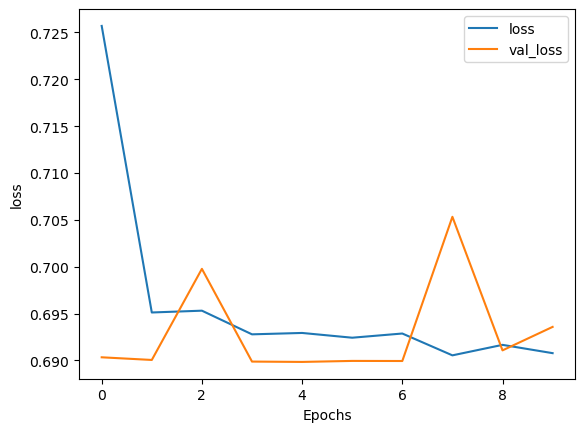

In [141]:
# display history

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(rnn_hist, "accuracy")
plot_graphs(rnn_hist, "loss")

In [46]:
y_pred = np.rint(model.predict(testing_padded))

y_pred


60/60 [==============================] - 5s 73ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [47]:

# confision matrix

# con_mat = tf.math.confusion_matrix(labels=testing_label, predictions=y_pred)
con_mat = confusion_matrix(y_test, y_pred)
con_mat



array([[923,   1],
       [974,   3]], dtype=int64)

In [48]:
# confision matrix normalized 
classes = [0,1]
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=3)
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
con_mat_df

,0,1
0,0.999,0.001
1,0.997,0.003


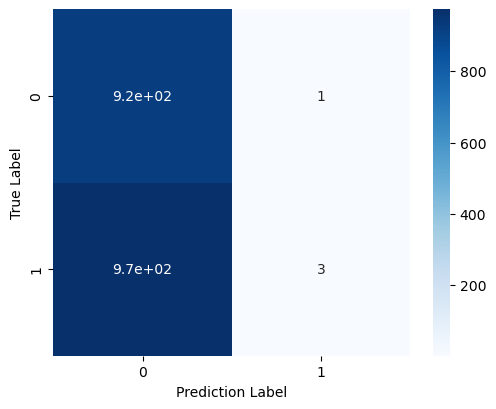

In [49]:
# display confision matrix

figure = plt.figure(figsize=(5,4))
sns.heatmap(con_mat, annot=True, cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Prediction Label')
plt.show()